In [ ]:
!pip install openai

In [ ]:
from    IPython.display     import Image
import  base64
import  time
import  matplotlib.pyplot   as plt
import  matplotlib.image    as mpimg

In [ ]:
from    openai              import OpenAI, RateLimitError

In [ ]:
from    google.colab        import userdata, widgets
KEY     = userdata.get( 'OA_TOKEN_P' )

In [ ]:
# set OpenAI API key
client          = OpenAI( api_key=KEY )

openai_errors   = ( RateLimitError, )
emergency_delay = 10

In [ ]:
MODEL       = "gpt-4-vision-preview"
TOP_P       = 1
TEMP        = 0.5
N_RET       = 4
MX_TOK      = 1000
DETAIL      = "high"

In [ ]:
def encode_b64( img ):
  with open( img, "rb") as f:
    return base64.b64encode( f.read() ).decode( 'utf-8' )

In [ ]:
def complete( prmpt, img_b64 ):
    message = [ {
        'role': 'user',
        'content': [
            { 'type': 'text',       'text': prmpt  },
            { 'type': 'image_url',  'image_url': {
                'url':      f"data:image/jpeg;base64,{img_b64}", # https://platform.openai.com/docs/guides/vision/uploading-base-64-encoded-images
                'detail':   DETAIL
                }
            }
        ]
    } ]

    try:
        res     = client.chat.completions.create(
            model       = MODEL,
            messages    = message,
            max_tokens  = MX_TOK,
            n           = N_RET,
            top_p       = TOP_P,
            temperature = TEMP
        )
    except openai_errors as e:
        delay   = emergency_delay
        if e is not RateLimitError:
            delay   = 5 * delay
        print( f"Catched error: {e}. Now sleeping for {delay} seconds." )
        time.sleep( delay )

        res     = client.chat.completions.create(
            model       = MODEL,
            messages    = message,
            max_tokens  = MX_TOK,
            n           = N_RET,
            top_p       = TOP_P,
            temperature = TEMP
        )

    return [ t.message.content for t in res.choices ]

In [ ]:
def print_res( prmpt, img, compl ):
    grid = widgets.Grid(2, 1)

    with grid.output_to( 0, 0 ):
        grid2 = widgets.Grid(1, 2)

        # Cell 1: input image
        with grid2.output_to( 0, 0 ):
            i = mpimg.imread( img )
            plt.imshow( i )
            plt.axis( 'off' )
            plt.show()

        # Cell 2: prompt
        with grid2.output_to( 0, 1 ):
            print( prmpt )

    # Cell 3: completions
    with grid.output_to( 1, 0 ):
        tabbar  = widgets.TabBar( [ f"COMPL-{i+1}" for i in range( N_RET ) ] )
        for i in range( N_RET ):
            with tabbar.output_to( f"COMPL-{i+1}" ):
                print( compl[ i ] )

In [ ]:
def do_exec( prmpt, img ):
    img_b64 = encode_b64( img )
    compl   = complete( prmpt, img_b64 )
    print_res( prmpt, img, compl )
    return compl

In [27]:
my_prompt = """
You're the mature driver behind the wheel and this image is what you see now.
Describe what you see and what are the relevant elements.
Then, describe what you plan to do accordingly.
"""

In [ ]:
my_image_1  = "c1.jpg"
my_image_2  = "c2.jpg"
my_image_3  = "c3.jpg"
my_image_4  = "c4.jpg"
my_image_5  = "c5.jpg"

!wget -O {my_image_1} https://www.dropbox.com/scl/fi/5fkn00h925xjf51jcodcj/c1.jpg?rlkey=2a7kjoqphqaz5mt1wl3c5bp4i&dl=0
!wget -O {my_image_2} https://www.dropbox.com/scl/fi/s5089zy9pt5ed10ocn46y/c2.jpg?rlkey=01qndot441zgst8g8cdz0emqw&dl=0
!wget -O {my_image_3} https://www.dropbox.com/scl/fi/u65cc3yaz91y45yu28eq8/c3.jpg?rlkey=6ynt5npd51k5z0zqy2k4s17fe&dl=0
!wget -O {my_image_4} https://www.dropbox.com/scl/fi/bsgk49gsylca970x78sg6/c4.jpg?rlkey=hfmlvuqwewu0rr63wxf0fsckm&dl=0
!wget -O {my_image_5} https://www.dropbox.com/scl/fi/gg3adv8kr7mj8nijkchva/c5.jpg?rlkey=rbmi57b4pefu730i0t07l2mot&dl=0

""
""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

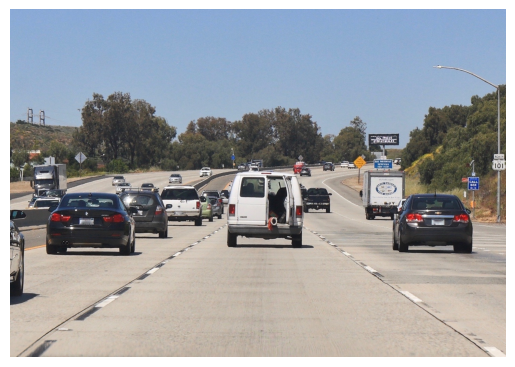

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


You're the mature driver behind the wheel and this image is what you see now.
Describe what you see and what are the relevant elements.
Then, describe what you plan to do accordingly.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

I see a multi-lane highway with moderate traffic. There are several vehicles in front of me, including a white van directly ahead in the same lane, which has its rear doors open and appears to be carrying traffic cones or some sort of cylindrical objects. The van's open doors and the cargo pose a potential hazard to road safety. There are other cars and trucks in adjacent lanes traveling at varying speeds.

Relevant elements include:
- The open doors of the van, which may reduce the predictability of the vehicle's movements and could lead to objects falling onto the road.
- The traffic density, which requires maintaining a safe following distance from other vehicles.
- The highway signs indicating an upcoming exit to the right and the presence of a call box.

Given this situation, I would plan to do the following:
1. Maintain a safe following distance from the van to ensure there's enough time to react if any objects fall out or if the van makes sudden movements.
2. Stay alert and watc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In the image, you are on a multi-lane highway with moderate traffic. There are several vehicles in front of you, including a white van in the center lane that has its rear doors open, revealing orange traffic cones and other equipment. This could potentially be a hazard if items were to fall out onto the roadway.

There are signs overhead indicating a junction or exit coming up, with one sign pointing towards a "Brake Check Area" and another indicating that the right lane will lead to a specific route. The traffic seems to be flowing smoothly, but it's important to be aware of the potential hazard posed by the open doors of the van.

As a mature driver, you should take the following actions:

1. Maintain a safe following distance from the vehicle ahead to provide ample time to react to any unexpected events, such as debris falling from the van.
2. Keep an eye on the van with the open doors and be prepared to take evasive action if necessary, such as changing lanes safely if it's clear 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In this image, we are on a multi-lane highway with moderate traffic. There are several vehicles in front of us, including a white van in the center lane with its rear doors open, which is a potential hazard. The traffic seems to be flowing smoothly, but the open doors of the van could pose a risk to other vehicles. There are also road signs indicating an upcoming exit for "San Diego" to the right, and a warning sign for a "Truck Check 1 Mile" ahead.

As a mature driver, my plan would be as follows:

1. Maintain a safe following distance from the car in front of me to provide ample time to react to any unforeseen events.
2. Keep an eye on the white van with open doors, as it could make unexpected movements or items could fall out, creating a hazard.
3. Be prepared to change lanes if it becomes necessary to avoid the van, but only do so after checking mirrors and blind spots to ensure it is safe to change lanes.
4. Stay aware of the upcoming exit and truck check, in case there might be v

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In this image, I see a multi-lane highway with moderate traffic. The vehicles are primarily cars, with some larger trucks and a van visible. The traffic appears to be flowing smoothly, but there are a few points to note:

1. Lane Usage: The vehicles are spread across multiple lanes, with some lanes appearing more congested than others.
2. Speed: There's no clear indication of speed, but since this is a highway setting, it's reasonable to assume vehicles are traveling at higher speeds.
3. Road Signs: There are signs indicating an upcoming interchange or junction, with directions for Highway 101 and an exit for "Beach Cities."
4. Road Conditions: The road appears to be dry and in good condition, with clear visibility.
5. Safety: There's a white van in the center of the image with its rear doors open and cones visible inside, which could potentially be a hazard if items were to fall out.

As a mature driver, my actions would include:

- Maintaining a safe following distance from the vehic

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
my_compl_1 = do_exec( my_prompt, my_image_1 )

""
""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

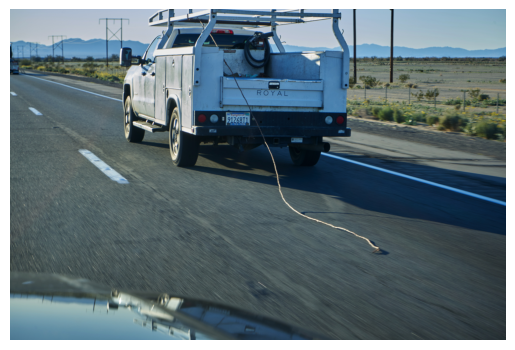

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


You're the mature driver behind the wheel and this image is what you see now.
Describe what you see and what are the relevant elements.
Then, describe what you plan to do accordingly.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In the image, you're driving on a multi-lane road, and directly in front of you is a white pickup truck with a utility bed. The truck is equipped with a ladder rack, and there appears to be a hose or a rope trailing from the back of the truck onto the road. The road appears to be in good condition, and the weather is clear. There are no visible pedestrians or immediate hazards other than the trailing object from the truck.

As a mature driver, the trailing hose or rope presents a potential road hazard. Here's what you should plan to do:

1. **Maintain a Safe Distance**: Increase your following distance from the truck to give yourself more time to react if the rope or hose were to cause any issues.

2. **Stay Alert**: Keep an eye on the truck and the rope, as well as your surroundings, to be prepared for any sudden movements from other vehicles.

3. **Consider Changing Lanes**: If it's safe to do so, and if you can maintain a proper distance after changing lanes, consider moving over to

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In the image, you're seeing a white utility truck on a multi-lane highway. The truck has a "ROYAL" logo on the back and is equipped with a storage compartment and a ladder rack. A significant safety concern is the rope that is trailing from the back of the truck onto the road. This poses a potential hazard for vehicles following the truck, as the rope could get entangled in the wheels or undercarriage of a trailing vehicle, leading to an accident.

As a mature driver, you should take the following actions to ensure safety:

1. Maintain a safe following distance from the truck to ensure you have enough time to react if the rope causes any unexpected issues.
2. Be prepared to take evasive action if necessary, such as changing lanes to avoid the rope if it starts to move unpredictably.
3. If it's safe to do so, you might consider signaling and moving to another lane to pass the truck, ensuring you do so at a safe distance to avoid the rope.
4. Once you are no longer behind the truck, if y

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In the image, you see a white utility truck traveling on a highway. The truck has a cargo area with equipment and a ladder attached to it. A notable safety concern is that there is a rope trailing from the back of the truck onto the road. This rope could potentially be a hazard to other vehicles if it were to get entangled in the wheels or undercarriage.

As a mature driver, the first thing to do is to maintain a safe distance from the truck to avoid any issues that could arise from the trailing rope. You should also be prepared to take evasive action if necessary, such as safely changing lanes if it is possible and legal to do so.

Additionally, if you can do so without compromising your safety or that of others, consider alerting the driver of the truck to the hazard by honking your horn or flashing your lights if it seems they are unaware of the trailing rope.

It is also important to stay vigilant and observe the traffic around you, as other drivers may also react to the rope. Alwa

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In the image, you're driving on a multi-lane highway and following a white utility truck. The truck has a ladder rack and various equipment in the back. There is a rope or a strap dragging on the road behind the truck, which is a safety hazard as it could get tangled with your vehicle or another's, or could cause an accident if it snags on something.

As a mature driver, you should take the following steps to ensure safety:

1. Maintain a safe following distance from the truck to give yourself enough time to react if the rope causes an issue.
2. If it is safe to do so, consider changing lanes to avoid the hazard altogether. Before changing lanes, check your mirrors and blind spots to ensure that the adjacent lane is clear.
3. Do not attempt to alert the driver of the truck by getting too close or engaging in risky maneuvers.
4. If you have a passenger, they could potentially alert the truck driver by calling a highway patrol or non-emergency police number, providing the truck's license

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
my_compl_2 = do_exec( my_prompt, my_image_2 )

""
""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

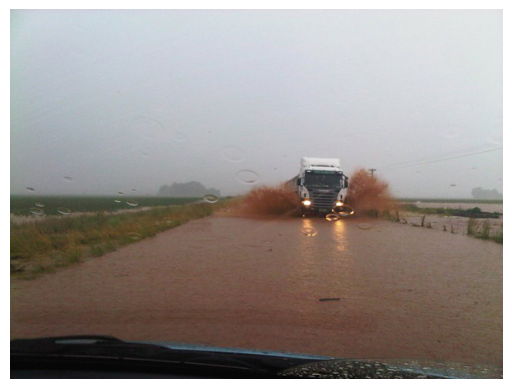

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


You're the mature driver behind the wheel and this image is what you see now.
Describe what you see and what are the relevant elements.
Then, describe what you plan to do accordingly.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In the image, I see a large truck coming towards me, creating a significant splash as it drives through a flooded section of the road. The visibility is reduced due to rain, as indicated by the raindrops on the windshield. The road appears to be a two-lane country road with no clear markings, and there's open land on either side, suggesting a rural area.

Relevant elements include:
- The oncoming truck, which is taking up a significant portion of the road.
- The flooded road, which could pose a risk to vehicles, especially smaller ones.
- The rain, which reduces visibility and could affect traction.

As a mature driver, my plan of action would be to:
1. Slow down immediately to reduce the risk of hydroplaning and maintain control of my vehicle.
2. Move to the right as far as safely possible to give the oncoming truck more space to pass.
3. Turn on my headlights if they aren't already on, to ensure I am visible to the truck driver.
4. Wait for the truck to pass before proceeding, watchi

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In the image, I see a large truck coming towards me, creating a significant wave of water as it drives through a flooded section of the road. The weather appears to be rainy, as indicated by the water droplets on the windshield. The road is surrounded by open fields, and visibility is likely reduced due to the weather conditions.

As a mature driver, my plan would be to proceed with caution. Here are the steps I would take:

1. Slow down: Reducing speed is crucial to maintain control of the vehicle on wet and potentially slippery roads.
2. Turn on headlights: If they are not already on, I would ensure that my vehicle's headlights are on to increase visibility to other drivers.
3. Keep a safe distance: I would maintain a generous following distance from the truck and any other vehicles to allow for plenty of reaction time.
4. Assess the situation: Before reaching the flooded area, I would assess the depth and breadth of the water. If it seems too deep or the current too strong, I would 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In the image, I see a large truck coming towards my direction, creating a significant splash as it drives through a flooded section of the road. The water is covering the entire road surface, and it's difficult to gauge the depth of the water from this perspective. It appears to be raining, as evidenced by the raindrops on the windshield. The surroundings suggest a rural or semi-rural area with open fields on either side of the road.

Given the situation, the relevant elements to consider are:

1. The oncoming truck: It's large and could potentially cause visibility issues due to the water it's displacing.
2. The flooded road: Driving through floodwaters can be dangerous as it can hide road damage, debris, or be deeper than it appears.
3. The rain: Reduced visibility and potentially slippery road conditions are factors to consider.

As a mature driver, my plan of action would be:

1. Slow down immediately to maintain control of the vehicle and to prepare for any unexpected movements fr

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In the image, you are viewing a flooded road from the perspective of a car driver. There is a large truck coming towards you, creating a significant splash as it drives through the water. The visibility is likely reduced due to the weather conditions, which seem to include rain, as indicated by the raindrops on the windshield. The road appears to be a single-lane rural or country road with open fields on either side.

Given the situation, the relevant elements to consider are:

1. The depth of the water on the road, which can be difficult to assess.
2. The potential risk of hydroplaning or loss of control due to the water.
3. The approaching truck, which could cause visibility issues due to the splash or even push more water towards your vehicle.
4. The lack of visible oncoming traffic lane markings, which makes it difficult to gauge a safe passing distance.

As a mature driver, your plan of action should be:

1. Slow down immediately to reduce the risk of hydroplaning.
2. Turn on your

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
my_compl_3 = do_exec( my_prompt, my_image_3 )

""
""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

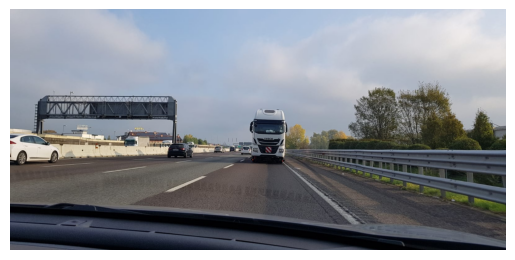

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


You're the mature driver behind the wheel and this image is what you see now.
Describe what you see and what are the relevant elements.
Then, describe what you plan to do accordingly.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In this image, you are driving on a multi-lane highway. There is a large truck in the oncoming lane traveling in the opposite direction, separated by a median barrier. The road appears to be dry, and visibility is good with daylight conditions. Traffic in your direction seems light with a white car ahead in the same lane and another vehicle in the left lane.

As a mature driver, you should be continuously assessing the road conditions, traffic, and your vehicle's position. Here are the steps you would take:

1. Maintain a safe following distance from the car ahead to give yourself enough time to react if they brake suddenly.

2. Stay aware of the vehicles in the left lane, as they may decide to change lanes into your lane.

3. Keep an eye on the truck in the opposite lane as a precaution, even though there is a median barrier.

4. Monitor the overhead gantry for any traffic signs or signals that might provide information about road conditions or speed limits.

5. Regularly check your m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In this image, you are driving on a multi-lane highway. There are several vehicles in view, including a white car on the left side of your lane, a black car ahead in the middle lane, and a large commercial truck traveling in the opposite direction on the other side of the central barrier. The road appears to be dry, and visibility is good with a clear sky.

Relevant elements to consider as a driver:

1. Following Distance: Ensure you maintain a safe following distance from the black car ahead. This will give you enough time to react if the car suddenly slows down or stops.

2. Lane Positioning: Stay centered in your lane to maintain a safe distance from other vehicles and the guardrail on the right.

3. Speed: Monitor your speed to ensure you're traveling at a safe speed that is appropriate for the road conditions and in accordance with speed limits.

4. Surroundings: Be aware of the traffic around you, including the white car to your left which may be in your blind spot if you decide 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In the image, you are driving on a multi-lane highway with moderate traffic. On the left side, there is a white car in the adjacent lane, slightly ahead of your position. Directly in front of you, there is a large white truck driving in the same direction, occupying the center of the lane. The truck appears to be in the correct lane for its size and type. There is a metal guardrail on the right side of the road, and the highway has multiple lanes for traffic in both directions, separated by concrete barriers.

The overhead gantry does not display any visible signs or information. The sky is partly cloudy, suggesting fair weather conditions. There are trees and some buildings visible in the background, indicating a suburban or semi-urban area.

As a mature driver, here are the steps you should take:

1. Maintain a safe following distance from the truck ahead to ensure you have enough time to react in case the truck brakes suddenly or any debris falls from it.
2. Stay alert and keep an e

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In the image, you are driving on a multi-lane highway. There is a large truck in the oncoming traffic lane driving towards you, which seems unusual and potentially dangerous since it is not in the correct lane for its direction of travel. The truck appears to be an Iveco commercial vehicle. There are also other cars in the correct lanes, including a white car to your left and another vehicle ahead of you in your lane.

Given this situation, the first thing to do is to ensure your safety and the safety of other road users:

1. Slow down: Gently reduce your speed without braking harshly to avoid causing a collision with vehicles behind you.

2. Stay alert: Keep an eye on the truck and be prepared for unexpected movements. Also, monitor the behavior of other drivers as they may also react unpredictably to the oncoming truck.

3. Move over: If it is safe to do so, and you can do it without endangering yourself or other road users, consider changing lanes to the left to increase the distanc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
my_compl_4 = do_exec( my_prompt, my_image_4 )